Supervised Learning

Task and Data

    The task we will perform is to quantitatively analyze forest cover change over time in the area surrounding the village Ces in Ticino, Switzerland
    We are provided with historic areal imagery from 1961 from swisstopo.
    The resolution of the imagery is 1 m/pixel and it contains only one single band (!!!)


In [28]:
import rasterio
import rasterio.plot 
from rasterio.transform import from_origin 
from rasterio.plot import plotting_extent
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import geopandas as gpd
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

In [29]:
# add path to your data
%cd /Users/scli/Documents/ZHAW/Teaching/Remote Sensing 24/Data

/Users/scli/Documents/ZHAW/Teaching/Remote Sensing 24/Data


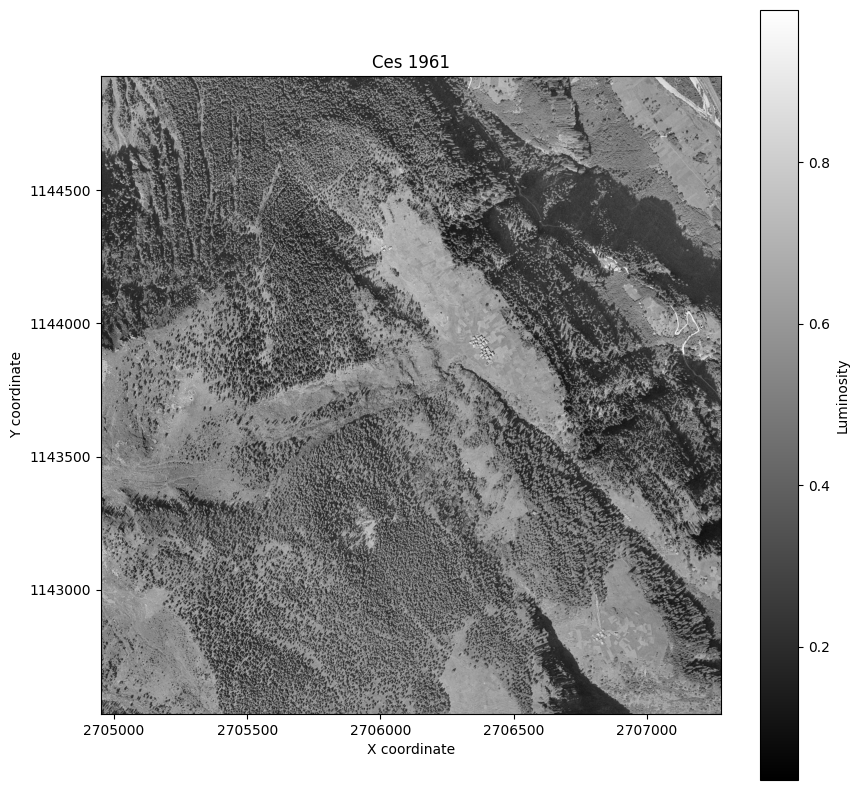

In [30]:
# Define the path to the .tif file using the current working directory
current_directory = os.getcwd()
tif_file_path = os.path.join(current_directory, "swisstopo/1961.tif")

# Open the .tif file
with rasterio.open(tif_file_path) as dataset:
    # Read the raster data as a numpy array
    ces1961 = dataset.read(1)  # reading the first band
    transform = dataset.transform

# Normalize the values to [0,1]
ces1961_normalized = ces1961 / 255.0

# Determine the extent in spatial coordinates
extent = rasterio.plot.plotting_extent(dataset)

# Define the formatter function to convert scientific notation to plain numbers
def to_plain_number(x, pos):
    return f'{x:.0f}'

# Plotting using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(ces1961_normalized, cmap='gray', extent=extent)
plt.colorbar(label='Luminosity')
plt.title('Ces 1961')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
# Customize tick formatting to avoid scientific notation
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_plain_number))
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_plain_number))
plt.show()


Data labelling

In preparation, I used QGIS to create labelled points for the following classes:

    Forest
    Buildings
    Agriculture
    Shadows


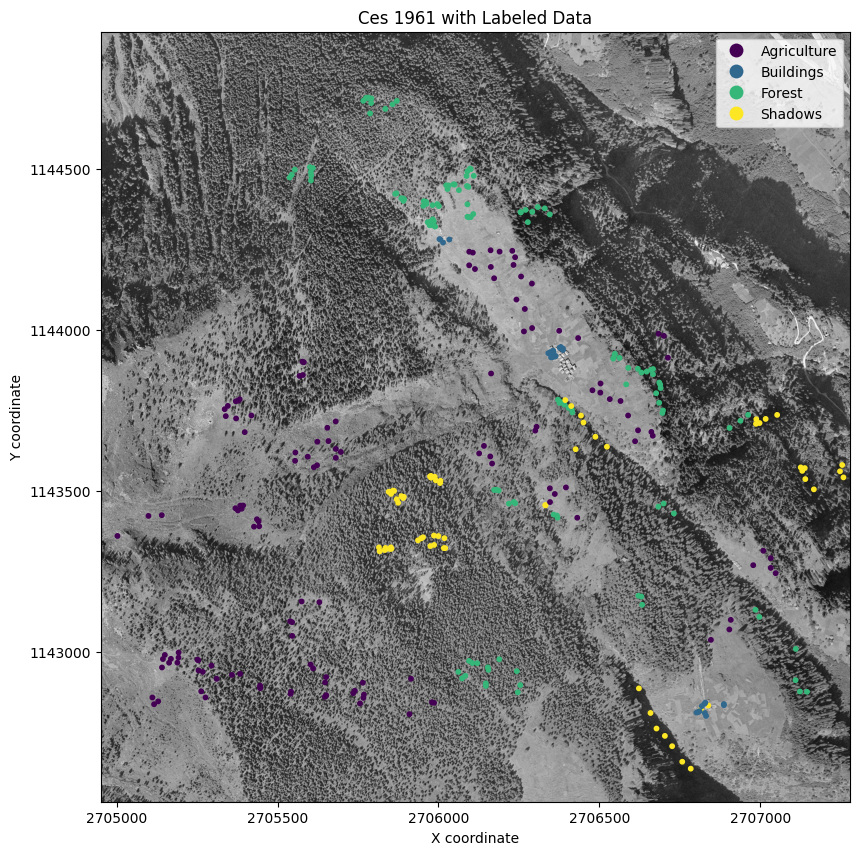

In [31]:
## Data Labelling

# Define the paths using the current working directory
gpkg_file_path = os.path.join(current_directory, "swisstopo/labelled-data.gpkg")

# Read the vector data
labelled_data = gpd.read_file(gpkg_file_path)

# Convert the 'class' column to categorical
labelled_data['class'] = labelled_data['class'].astype('category')

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
# Plot raster data
plt.imshow(ces1961_normalized, cmap='gray', extent=rasterio.plot.plotting_extent(dataset), norm=Normalize())
# Plot vector data
labelled_data.plot(ax=ax, column='class', legend=True, cmap='viridis', markersize=10)
# Adjust layout
ax.set_title('Ces 1961 with Labeled Data')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
# Customize tick formatting to avoid scientific notation
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_plain_number))
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_plain_number))
plt.show()

Splitting the data

    We need to split our data into training and testing data
    We will randomly select 70% of the data for training and the remaining 30% for testing


In [52]:
## Splitting the data

# Assuming 'labelled_data' is your input DataFrame
np.random.seed(42)  # Set the seed for reproducibility

# Shuffle the entire DataFrame
labelled_data_shuffled = labelled_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split by ensuring 70-30 split for each class
data_train_list = []
data_test_list = []

# Group data by class to maintain proportions
for class_label, group in labelled_data_shuffled.groupby('class'):
    # Determine split size
    train_size = int(len(group) * 0.7)
    
    # Split the group
    data_train_chunk = group.iloc[:train_size]
    data_test_chunk = group.iloc[train_size:]
    
    # Collect the splits
    data_train_list.append(data_train_chunk)
    data_test_list.append(data_test_chunk)

# Concatenate the collected DataFrames
data_train = pd.concat(data_train_list).reset_index(drop=True)
data_test = pd.concat(data_test_list).reset_index(drop=True)

# Assuming data_train and data_test are your split datasets
# Shuffle the resulting datasets to ensure random distribution of samples
data_train = data_train.sample(frac=1, random_state=42).reset_index(drop=True)
data_test = data_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Optional: Print the first few rows to verify
print(data_train.head())
print(data_test.head())

         class                         geometry
0       Forest   POINT (2705962.315 1144392.76)
1  Agriculture  POINT (2706346.759 1143465.656)
2    Buildings  POINT (2706014.148 1144272.433)
3  Agriculture  POINT (2706503.699 1143834.248)
4    Buildings  POINT (2706361.604 1143918.234)
         class                         geometry
0       Forest  POINT (2705834.842 1144688.129)
1  Agriculture  POINT (2705445.799 1142891.503)
2  Agriculture  POINT (2706611.137 1143654.776)
3       Forest  POINT (2706094.926 1142971.742)
4       Forest  POINT (2706686.436 1143837.237)


/var/folders/jv/jvcxtxx14p73bgbryl0jn21r0000gr/T/ipykernel_65813/1401330605.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for class_label, group in labelled_data_shuffled.groupby('class'):


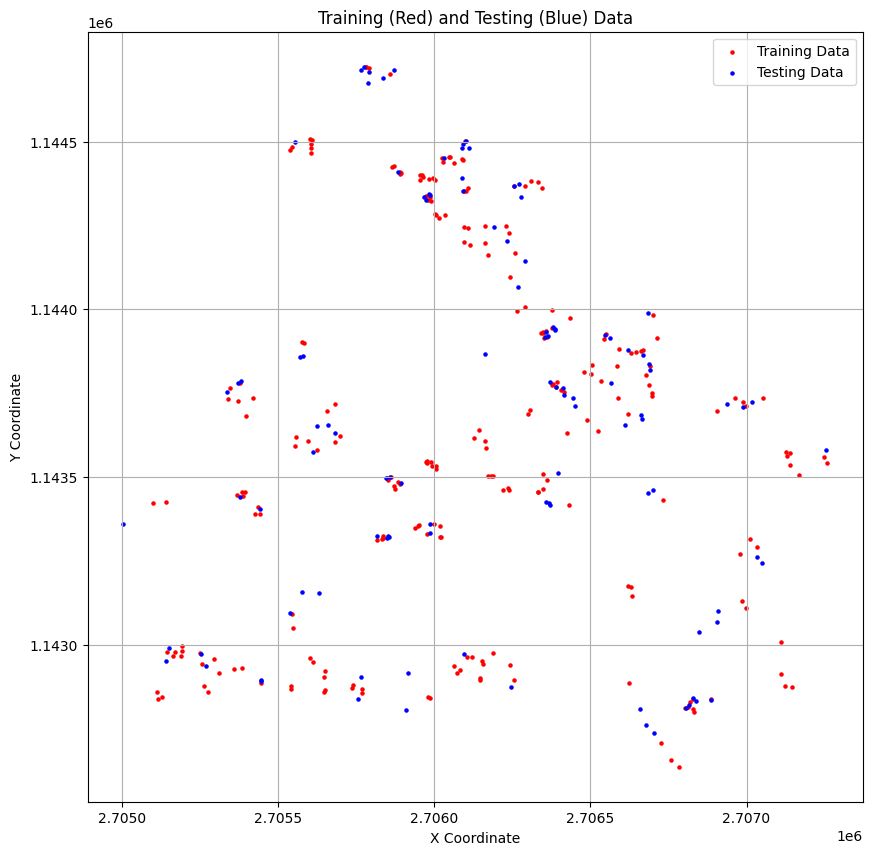

In [53]:
# Function to extract x, y coordinates from the Point objects
def extract_coordinates(geometry_series):
    x_coords = [point.x for point in geometry_series]
    y_coords = [point.y for point in geometry_series]
    return x_coords, y_coords

# Extract coordinates from geometry
train_x, train_y = extract_coordinates(data_train['geometry'])
test_x, test_y = extract_coordinates(data_test['geometry'])

# Create the plot
plt.figure(figsize=(10, 10))

# Plot training data (in red)
plt.scatter(train_x, train_y, c='red', label='Training Data', s=5)

# Plot testing data (in blue)
plt.scatter(test_x, test_y, c='blue', label='Testing Data', s=5)

# Customize plot
plt.title('Training (Red) and Testing (Blue) Data')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)

plt.show()

Feature Extraction

    We need to extract the values of the raster data at the labelled points
    Since we only have one band, our result is a data.frame with one column


In [54]:
## Feature Extraction

# Function to extract raster values at point locations
def extract_raster_values(raster, transform, points):
    raster_values = []
    for point in points.geometry:
        row, col = ~transform * (point.x, point.y)
        if 0 <= int(row) < raster.shape[0] and 0 <= int(col) < raster.shape[1]:
            raster_values.append(raster[int(row), int(col)])
        else:
            raster_values.append(np.nan)  # Handle out-of-bounds as NaN
    return raster_values

# Extract raster values for training data
train_features = extract_raster_values(ces1961_normalized, transform, data_train)
test_features = extract_raster_values(ces1961_normalized, transform, data_test)

# Convert extracted features to a DataFrame
train_features_df = pd.DataFrame(train_features, columns=['luminosity'])
test_features_df = pd.DataFrame(test_features, columns=['luminosity'])

# Combine with original training dataframe, dropping geometry
data_train2 = pd.concat([data_train.reset_index(drop=True), train_features_df], axis=1).drop(columns='geometry')
data_test2 = pd.concat([data_test.reset_index(drop=True), test_features_df], axis=1).drop(columns='geometry')

# Display the head of the combined data
print(train_features_df.head())
print(data_train2.head())
print(data_train2['class'])

print(data_test2.head())

   luminosity
0    0.717647
1    0.615686
2    0.141176
3    0.384314
4    0.121569
         class  luminosity
0       Forest    0.717647
1  Agriculture    0.615686
2    Buildings    0.141176
3  Agriculture    0.384314
4    Buildings    0.121569
0           Forest
1      Agriculture
2        Buildings
3      Agriculture
4        Buildings
          ...     
245      Buildings
246    Agriculture
247    Agriculture
248         Forest
249      Buildings
Name: class, Length: 250, dtype: category
Categories (4, object): ['Agriculture', 'Buildings', 'Forest', 'Shadows']
         class  luminosity
0       Forest    0.650980
1  Agriculture    0.286275
2  Agriculture    0.388235
3       Forest    0.305882
4       Forest    0.533333


Training the model

    We will use the rpart package to train a classification tree.
    The classification tree is also known as a decision tree.
    A decision tree has a flowchart-like structure.
    Classification trees does not always produce the best results, but they are simple and interpretable.


In [55]:
### Training the model

# Ensure the class column is a categorical type
# data_train['class'] = data_train['class'].astype('category')

# Prepare the feature and target data
X_train = data_train2.drop(columns=['class'])
y_train = data_train2['class']

# Assuming `data_test2` is your test DataFrame
X_test = data_test2.drop(columns=['class'])
y_test = data_test2['class']

# Train the Decision Tree model
# cart_model = DecisionTreeClassifier(max_depth=10)  # Limit depth for clarity
cart_model = DecisionTreeClassifier(max_depth=5)  # Limit depth for clarity
cart_model.fit(X_train, y_train)

# Predict on training data
y_train_pred = cart_model.predict(X_train)

# Predict on test data
y_test_pred = cart_model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.53
Test Accuracy: 0.39



    As mentioned above, the decision tree is interpretable. We can visualize it.
    Each pixel is classified into one of the four classes based on its value (luminosity).


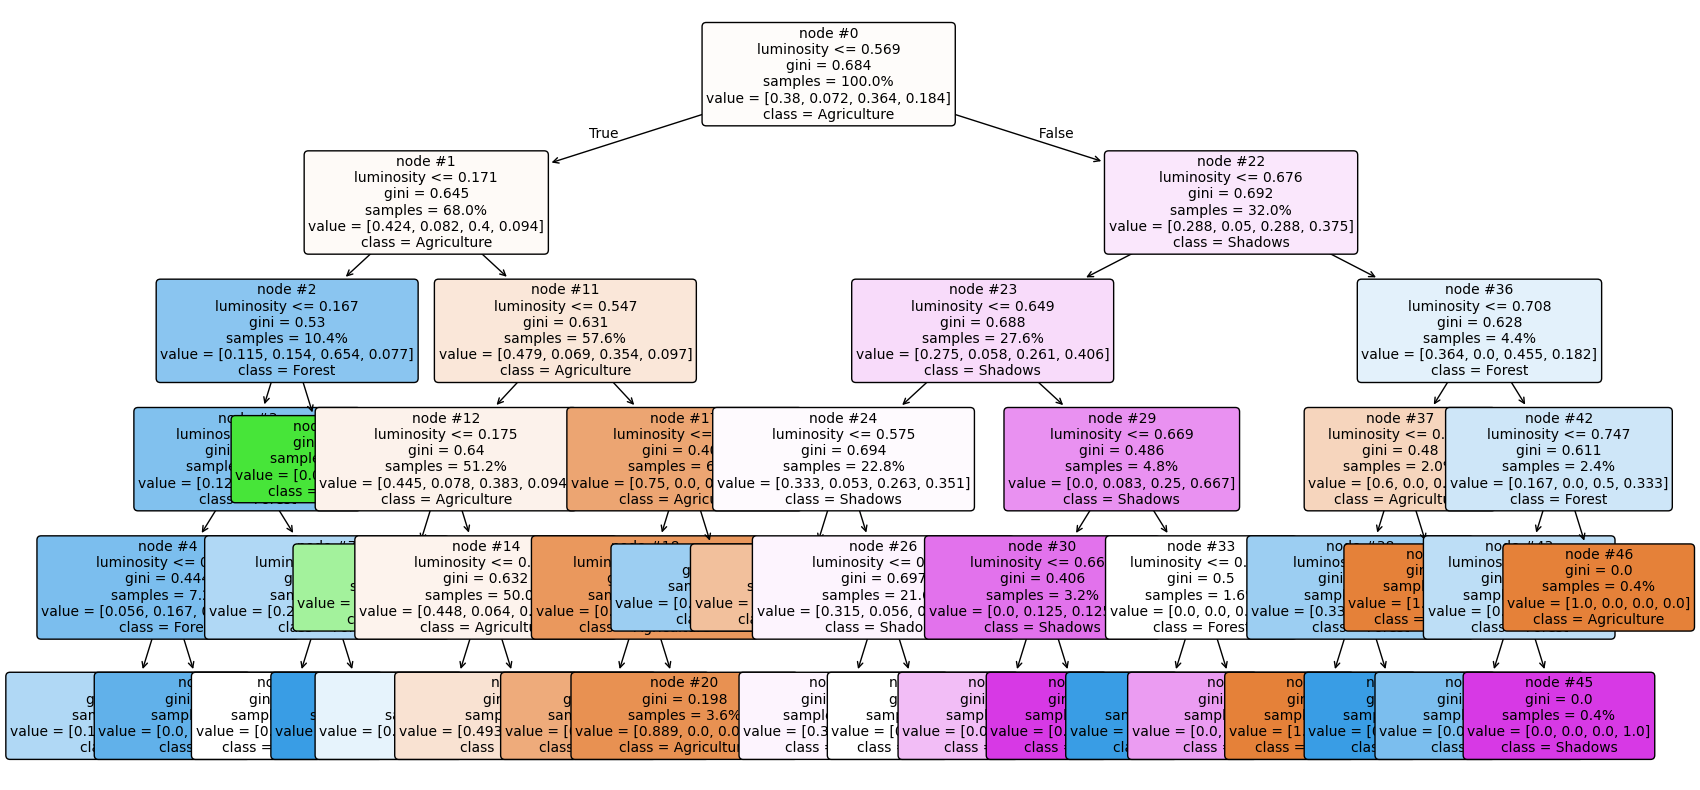

In [56]:
# Get class probabilities
node_probabilities = cart_model.tree_.value / cart_model.tree_.value.sum(axis=2, keepdims=True)

# Plot the decision tree
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(cart_model,
          feature_names=X_train.columns,
          class_names=cart_model.classes_,
          filled=True,
          rounded=True,
          proportion=True,
          node_ids=True,
          fontsize=10,
          ax=ax)

# Annotate nodes with class probabilities
for i in range(cart_model.tree_.node_count):
    ax.annotate(f"Probs: {node_probabilities[i].flatten()}",
                xy=(cart_model.tree_.threshold[i], -1.5), xycoords='data',
                fontsize=8, ha='right', va='center', bbox=dict(boxstyle="round,pad=0.3", ec="gray", fc="white", alpha=0.8))
plt.show()

Predicting the probabilities per class for each pixel

    We will use the trained model to predict the probabilities of each class for each pixel in the raster data.
    We can use the predict function to do this.
    The result is a raster with one layer per class, giving the probability of each class for each pixel.


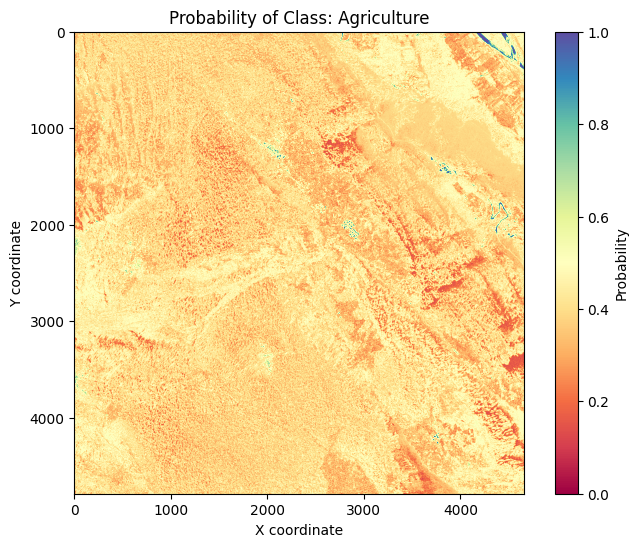

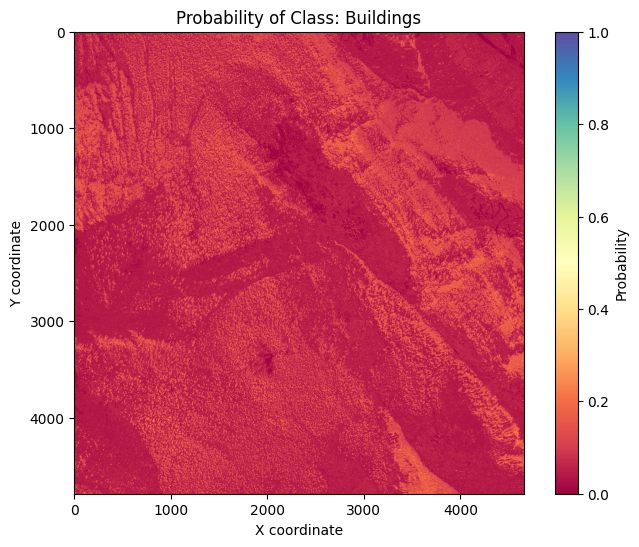

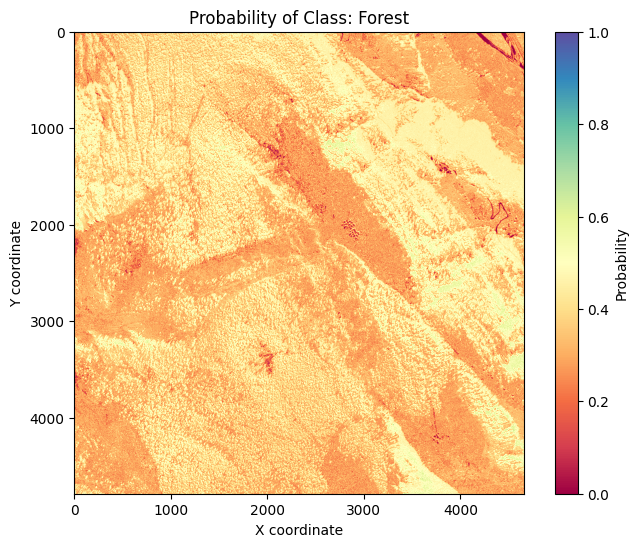

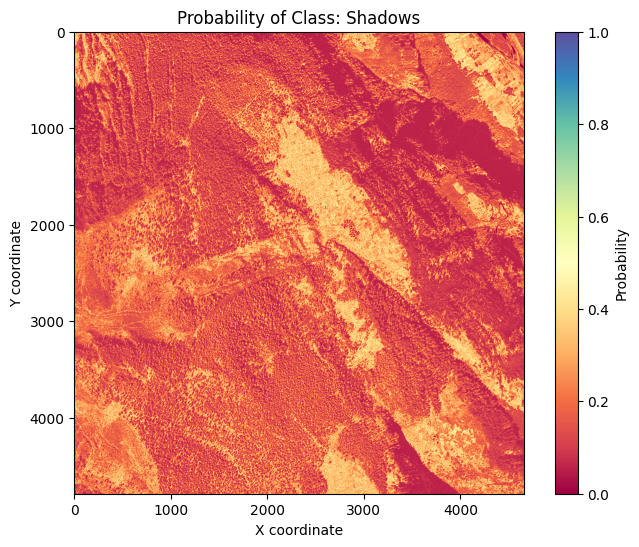

In [57]:
# Assuming model 'cart_model' is already trained
# and 'ces1961_normalized' is the normalized raster data
raster_flat = ces1961_normalized.flatten().reshape(-1, 1)  # Ensure data is 2D for sklearn

# Create DataFrame for raster with correct feature name
raster_df = pd.DataFrame(raster_flat, columns=['luminosity'])
# Predict probabilities using the trained model
ces1961_predict_probs = cart_model.predict_proba(raster_df)

# Reshape probability arrays to match the raster dimensions
class_count = len(cart_model.classes_)
probs_raster = [ces1961_predict_probs[:, i].reshape(ces1961_normalized.shape) for i in range(class_count)]

# Plot the probability raster for each class
for i, class_name in enumerate(cart_model.classes_):
    plt.figure(figsize=(8, 6))
    plt.imshow(probs_raster[i], cmap='Spectral', vmin=0, vmax=1)
    plt.colorbar(label='Probability')
    plt.title(f'Probability of Class: {class_name}')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

Highest probability class

    We can combine the four layers into a single layer by assigning the class with the highest probability to each pixel.
    For this, we can use the which.max function:


/Users/scli/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


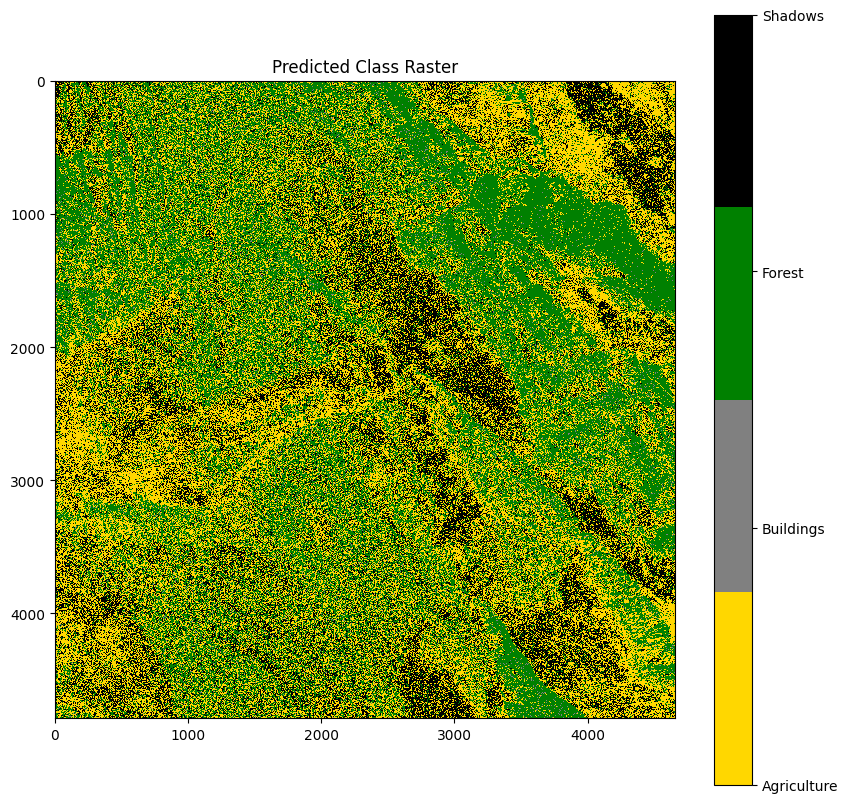

In [58]:
# Reshape raster data for prediction
raster_flat = ces1961_normalized.flatten().reshape(-1, 1)  # Ensure data is 2D for sklearn

# Predict class probabilities
ces1961_predict_probs = cart_model.predict_proba(raster_flat)

# Get class predictions by finding the index with maximum probability
ces1961_predict2 = np.argmax(ces1961_predict_probs, axis=1).reshape(ces1961_normalized.shape)

# Map class indices back to the class names
classes = data_train2['class'].cat.categories
ces1961_predict_labeled = np.asarray([classes[i] for i in ces1961_predict2.flatten()]).reshape(ces1961_normalized.shape)

# Convert class labels back to numeric indices for visualization
label_to_index = {label: index for index, label in enumerate(classes)}
ces1961_predict_numerical = np.vectorize(label_to_index.get)(ces1961_predict_labeled)

# Example colors
custom_colors = ['gold', 'grey', 'green', 'black']
custom_cmap = ListedColormap(custom_colors)
# Plot using numeric indices
plt.figure(figsize=(10, 10))
plt.imshow(ces1961_predict_numerical, cmap=custom_cmap, interpolation='nearest')
plt.title('Predicted Class Raster')
plt.colorbar(ticks=range(len(classes)), format=plt.FuncFormatter(lambda val, loc: classes[val]))
plt.show()

In [59]:
print(classes)

Index(['Agriculture', 'Buildings', 'Forest', 'Shadows'], dtype='object')


Model Evaluation

    To evaluate the model, we will use the testing data.


In [60]:
# Extract predicted classes for test data
test_features = extract_raster_values(ces1961_predict2, transform, data_test)

# Compare predicted and actual classes
confusion_matrix = pd.crosstab(pd.Series(test_features, name='Predicted'),
                               data_test['class'], rownames=['Predicted'], colnames=['Actual'])

print(confusion_matrix)

# Sum the diagonal of the confusion matrix to get the number of correct predictions
correct_predictions = np.trace(confusion_matrix)
# Sum all elements to get the total number of predictions
total_predictions = confusion_matrix.to_numpy().sum()
# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")

Actual     Agriculture  Buildings  Forest  Shadows
Predicted                                         
0                   18          4      13        6
1                    1          0       3        0
2                   15          5      16        6
3                    7          0       7        8
Accuracy: 38.53%
